

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Benötigte Bibliotheken laden
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
#Einlesen des Dataset
customer_data = '/content/drive/MyDrive/Colab Notebooks/BA_DATA.xlsx'
raw_data = pd.read_excel(customer_data)

#1. Datenbereinigung

In [ ]:
#Untersuchung der Daten
print("Das Dataset hat folgende Anzahl an... ")
print("Zeilen:",len(raw_data))
print("Spalten",len(raw_data.columns))
print(raw_data.head(),"\n")
print("Das Dataset hat folgende Spaltennamen: ")
print(list(raw_data.columns), "\n")

Das Dataset hat folgende Anzahl an... 
Zeilen: 9994
Spalten 17
    Product Product Number  Invoice Number Invoice Date  Year Year / Month  \
0  Product1         OLSP17           22767   07.01.2019  2019      2019_01   
1  Product2         PAPC16           22769   08.01.2019  2019      2019_01   
2  Product3         TOGS15           22769   08.01.2019  2019      2019_01   
3  Product4         MAVA15           22769   08.01.2019  2019      2019_01   
4  Product5         TUCO33           22769   08.01.2019  2019      2019_01   

  Customer Group Customer Number  Zip Code Customer Warehouse Identification   \
0           GVPI       Customer1              22848                       UNI   
1           GVPI       Customer2              22113                       UNI   
2           GVPI       Customer2              22113                       UNI   
3           GVPI       Customer2              22113                       UNI   
4           GVPI       Customer2              22113            

In [ ]:
#Entfernen von redundanten Spalten
data = raw_data.drop(['Product Group', 'Customer Group', 'Year', 'Year / Month'], axis = 1)
print("Nach dem Entfernen redundanter Spalten:")
print(data.head(),"\n")

Nach dem Entfernen redundanter Spalten:
    Product Product Number  Invoice Number Invoice Date Customer Number  \
0  Product1         OLSP17           22767   07.01.2019       Customer1   
1  Product2         PAPC16           22769   08.01.2019       Customer2   
2  Product3         TOGS15           22769   08.01.2019       Customer2   
3  Product4         MAVA15           22769   08.01.2019       Customer2   
4  Product5         TUCO33           22769   08.01.2019       Customer2   

   Zip Code Customer Warehouse Identification    Supplier Stock Unit  \
0              22848                       UNI  Supplier1        Ds.   
1              22113                       UNI  Supplier2        Ds.   
2              22113                       UNI  Supplier3        Ds.   
3              22113                       UNI  Supplier4        Ds.   
4              22113                       UNI  Supplier5        Ds.   

   Quantity PU (Packaging Unit) Packaging Unit Conditions of Delivery  \
0  

In [ ]:
#Entfernen des String "Customer" in Spalte "Customer Number" und behalten der Zahlenwerte als Integer
data['Customer Number'] = data['Customer Number'].str.replace('Customer', '', regex=False).astype(int)

In [ ]:
#Überprüfung auf leere Einträge. Wenn vorhanden, dann anzeigen.
if data.isna().sum().sum() > 0:
    print("Spalten mit fehlenden Werten:")
    print(data.isna().sum())
else:
    print("Der Datensatz besitzt KEINE leeren Zellen.\n")

Der Datensatz besitzt KEINE leeren Zellen.



In [ ]:
#Überprüfung auf Duplikate. Wenn vorhanden, dann anzeigen und anschließend entfernen.
duplicates = data[data.duplicated(keep=False)]
if not duplicates.empty:
    print("Der Datensatz beinhaltet folgende doppelte Zeilen: ")
    print(duplicates)
    print("Anzahl der Duplikate: ", data.duplicated().sum(), "\n")
    data = data.drop_duplicates(keep='first')
    print("Anzahl der Duplikate nach Bereinigung: ", data.duplicated().sum(), "\n")
else:
    print("Der Datensatz beinhaltet KEINE Duplikate.\n")

Der Datensatz beinhaltet folgende doppelte Zeilen: 
        Product Product Number  Invoice Number Invoice Date  Customer Number  \
6371  Product19         ARHE07           54771   18.05.2022                6   
6373  Product19         ARHE07           54771   18.05.2022                6   

      Zip Code Customer Warehouse Identification    Supplier Stock Unit  \
6371              75203                       UNI  Supplier7        Ds.   
6373              75203                       UNI  Supplier7        Ds.   

      Quantity PU (Packaging Unit) Packaging Unit Conditions of Delivery  \
6371                          12.0            k12                    DDP   
6373                          12.0            k12                    DDP   

     Batch Number  
6371     E1462013  
6373     E1462013  
Anzahl der Duplikate:  1 

Anzahl der Duplikate nach Bereinigung:  0 



In [ ]:
#Umstellung des Datumformats
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'], format = "%d.%m.%Y", errors='coerce')

print("Anzahl der Zeilen nach Bereinigung: ",len(data),"\n")
#Bereinigten Datensatz speichern
data.to_excel("data_cleaned.xlsx", index=False)
print("Der bereinigte Datensatz wurde als 'data_cleaned.xlsx' gespeichert\n")

Anzahl der Zeilen nach Bereinigung:  9993 

Der bereinigte Datensatz wurde als 'data_cleaned.xlsx' gespeichert





---



In [ ]:
#Bereinigten Datensatz einlesen
data = pd.read_excel("data_cleaned.xlsx")

# 2. Bestellintervalle

In [ ]:
# 1. Dubletten entfernen, damit pro Kunde und Invoice Number nur noch eine Zeile existiert
data_unique = data.drop_duplicates(subset=['Invoice Number' , 'Invoice Date', 'Customer Number']).copy()

In [ ]:
# Sortiere den Datensatz nach 'Customer Number' und 'Invoice Date' (aufsteigend)
data_unique = data_unique.sort_values(by=['Customer Number', 'Invoice Date'])

In [ ]:
# Berechnung der Zeitabstände (in Tagen) zwischen Bestellungen jedes Kunden
data_unique['time_difference_days'] = data.groupby('Customer Number')['Invoice Date'].diff().dt.days

In [ ]:
# Definierung der Intervalle und ihre Labels
bin_edges = [0, 1, 7, 14, 30, 90, 183, 365, np.inf]
bin_labels = ["Selber Tag", "< 1 Woche", "1-2 Wochen", "3-4 Wochen", "1-3 Monaten", "4-6 Monaten", "1 Jahr", "über 1 Jahr"]

In [ ]:
# Kategorisierung der Zeitabstände
data_unique['Interval Category'] = pd.cut(data_unique['time_difference_days'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [ ]:
# Zählen der Häufigkeiten der Intervalle
bin_counts = data_unique['Interval Category'].value_counts(sort=False)

In [ ]:
# Berechnung der Gesamtanzahl und die prozentuale Verteilung
total_count = bin_counts.sum()
bin_percentages = (bin_counts / total_count) * 100

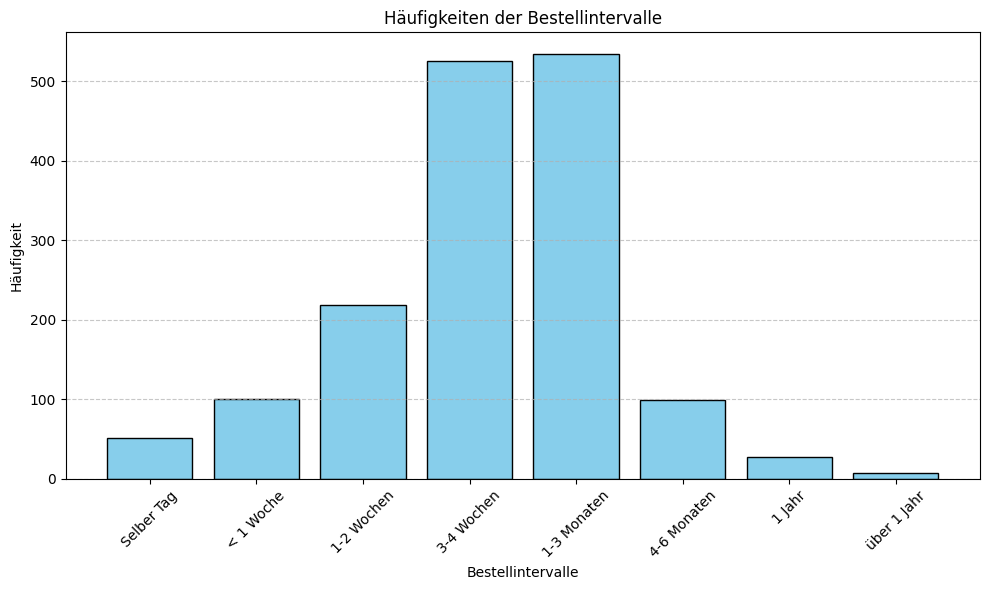

In [ ]:
# Plot 1: Histogramm der Bestellintervalle

plt.figure(figsize=(10, 6))
plt.bar(bin_counts.index.astype(str), bin_counts.values, color='skyblue', edgecolor='black')
plt.title("Häufigkeiten der Bestellintervalle")
plt.xlabel("Bestellintervalle")
plt.ylabel("Häufigkeit")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


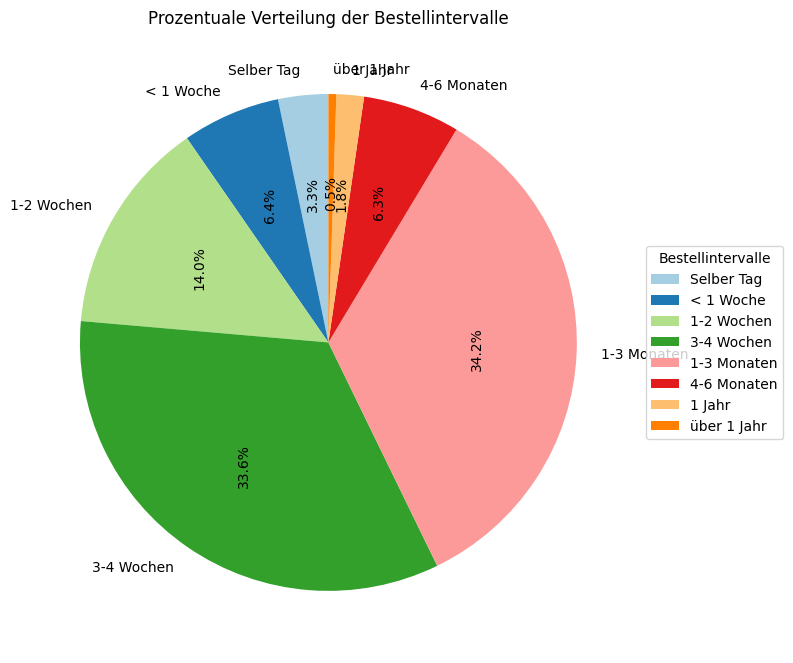

In [ ]:
# Plot 2: Kuchendiagramm der prozentualen Verteilung
plt.figure(figsize=(8, 8))
colors = plt.cm.Paired(range(len(bin_percentages)))  # Passende Farben generieren
wedges, texts, autotexts = plt.pie(
    bin_percentages.values,
    labels=bin_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}

)
# Rotation der Prozentzahlen anpassen
for autotext in autotexts:
    autotext.set_rotation(90)  # Drehung um 90 Grad
# Legende hinzufügen
plt.legend(wedges, bin_labels, title="Bestellintervalle", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Prozentuale Verteilung der Bestellintervalle")
plt.tight_layout()
plt.show()

#3. Zeitliche Bestellmuster Analyse

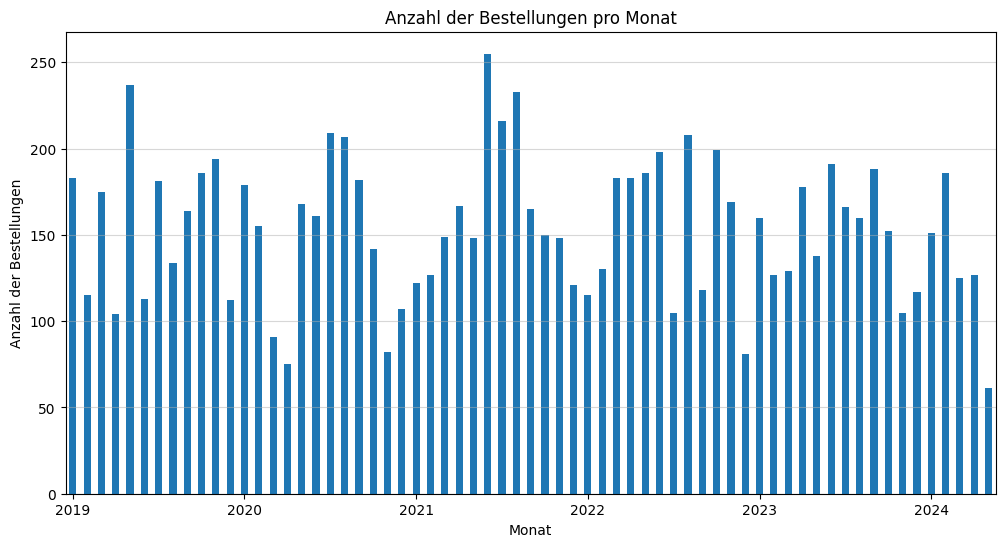

In [ ]:
#Plot 3: Anzahl Bestellungen pro Monat über 5 Jahre
data['Month'] = data['Invoice Date'].dt.to_period('M')
monthly_orders = data.groupby('Month')['Invoice Date'].count()

plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='bar',  label="monatlichen Bestellungen")
plt.title("Anzahl der Bestellungen pro Monat")
plt.xlabel("Monat")
plt.ylabel("Anzahl der Bestellungen")
plt.grid(axis='y', alpha=0.5)
# Setzung der x-Achsen-Beschriftungen auf die gewünschten Jahre
plt.xticks(ticks=[0, 12, 24, 36, 48, 60], labels=['2019', '2020', '2021', '2022', '2023', '2024'], rotation=0)
plt.show()


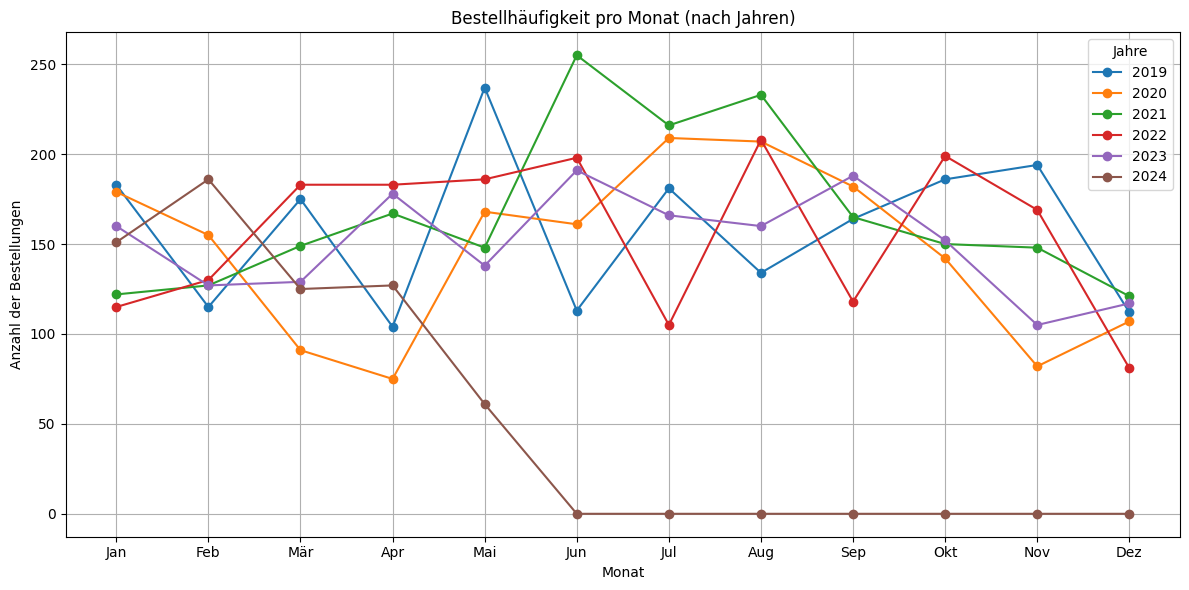

In [ ]:
#Plot 4: Anzahl Bestellungen pro Monat (Jahre seperat)

# Monat und Jahr extrahieren
data['Year'] = data['Invoice Date'].dt.year
data['Month'] = data['Invoice Date'].dt.month

# Aggregierung der Anzahl der Bestellungen nach Jahr und Monat
monthly_orders_by_year = data.groupby(['Year', 'Month'])['Invoice Date'].count().unstack(level=0, fill_value=0)

# Erstellung der Plots für jedes Jahr
plt.figure(figsize=(12, 6))


for year in monthly_orders_by_year.columns:
    plt.plot(
        monthly_orders_by_year.index,
        monthly_orders_by_year[year],
        marker='o', label=f"{year}"
    )


plt.title("Bestellhäufigkeit pro Monat (nach Jahren)")
plt.xlabel("Monat")
plt.ylabel("Anzahl der Bestellungen")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
plt.grid()
plt.legend(title="Jahre")
plt.tight_layout()
plt.show()

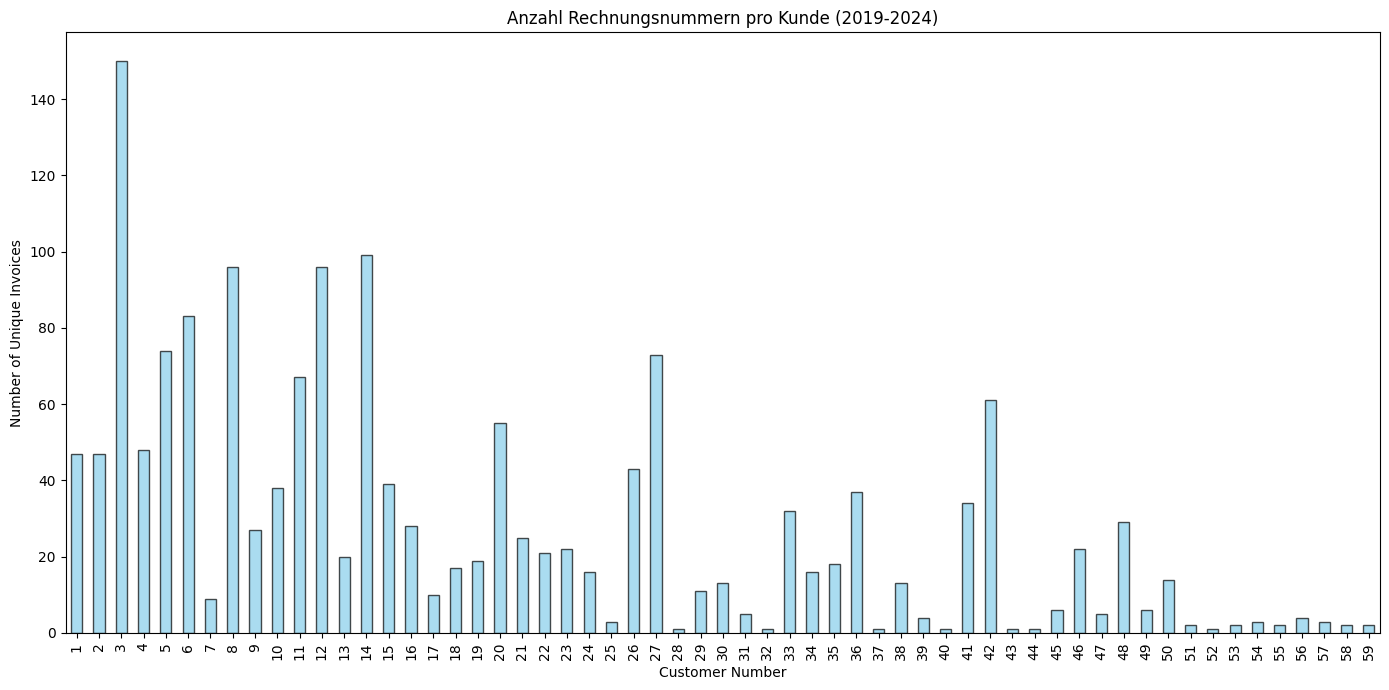

In [ ]:
# Berechnung der Anzahl von Rechnungen pro Kunde über 5 Jahre
unique_invoices_per_customer = data.groupby('Customer Number')['Invoice Number'].nunique()

# Visualisierung der Verteilung
plt.figure(figsize=(14, 7))
unique_invoices_per_customer.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Anzahl Rechnungsnummern pro Kunde (2019-2024)")
plt.xlabel("Customer Number")
plt.ylabel("Number of Unique Invoices")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

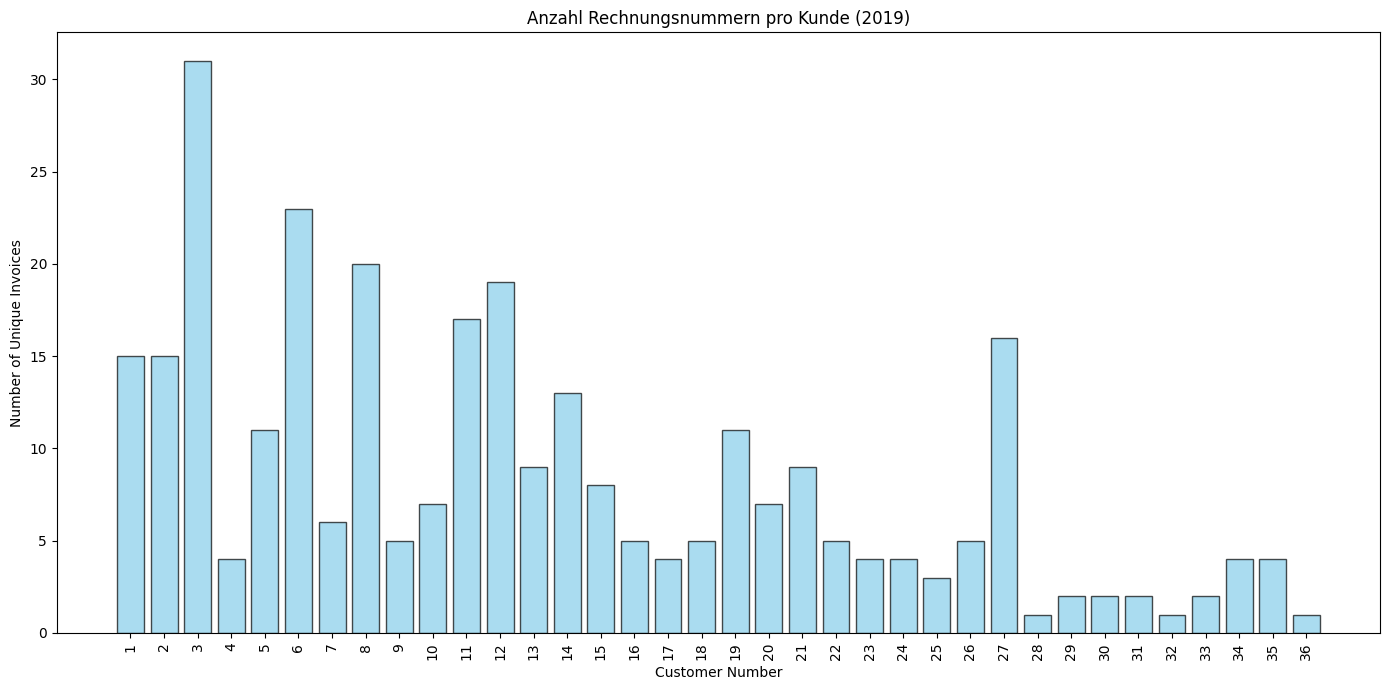

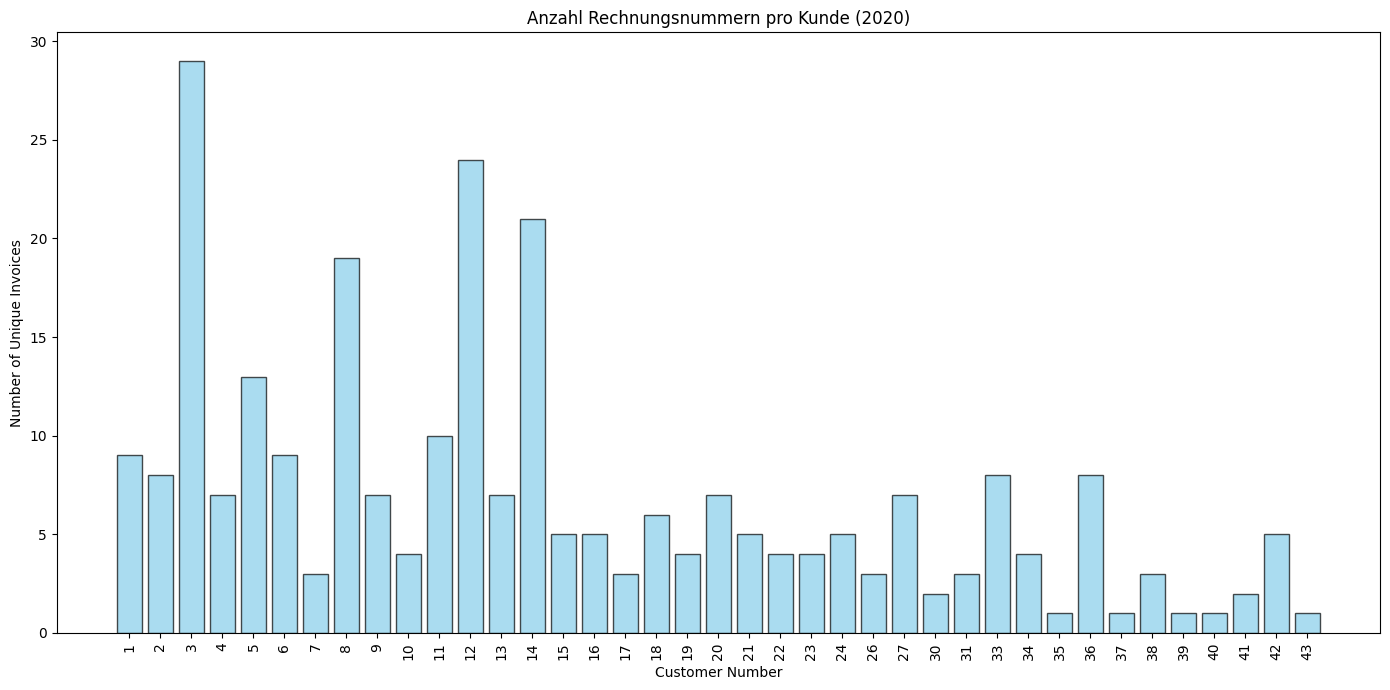

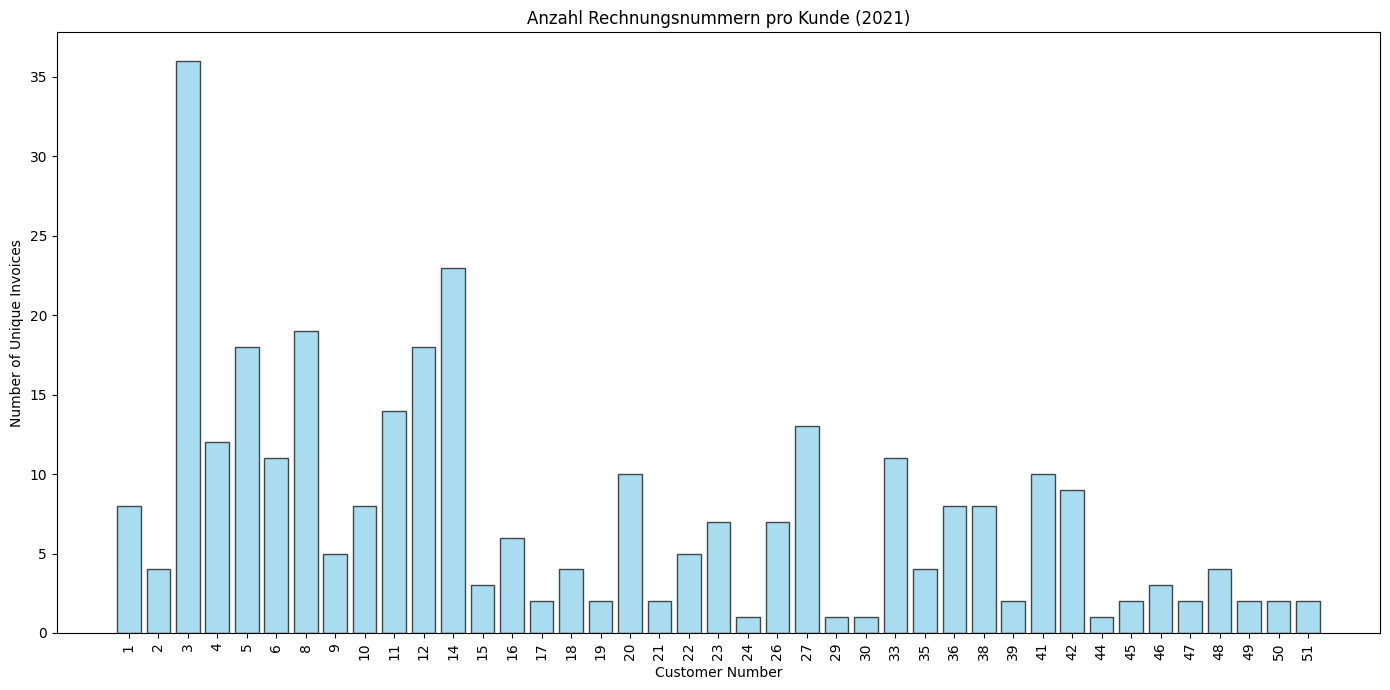

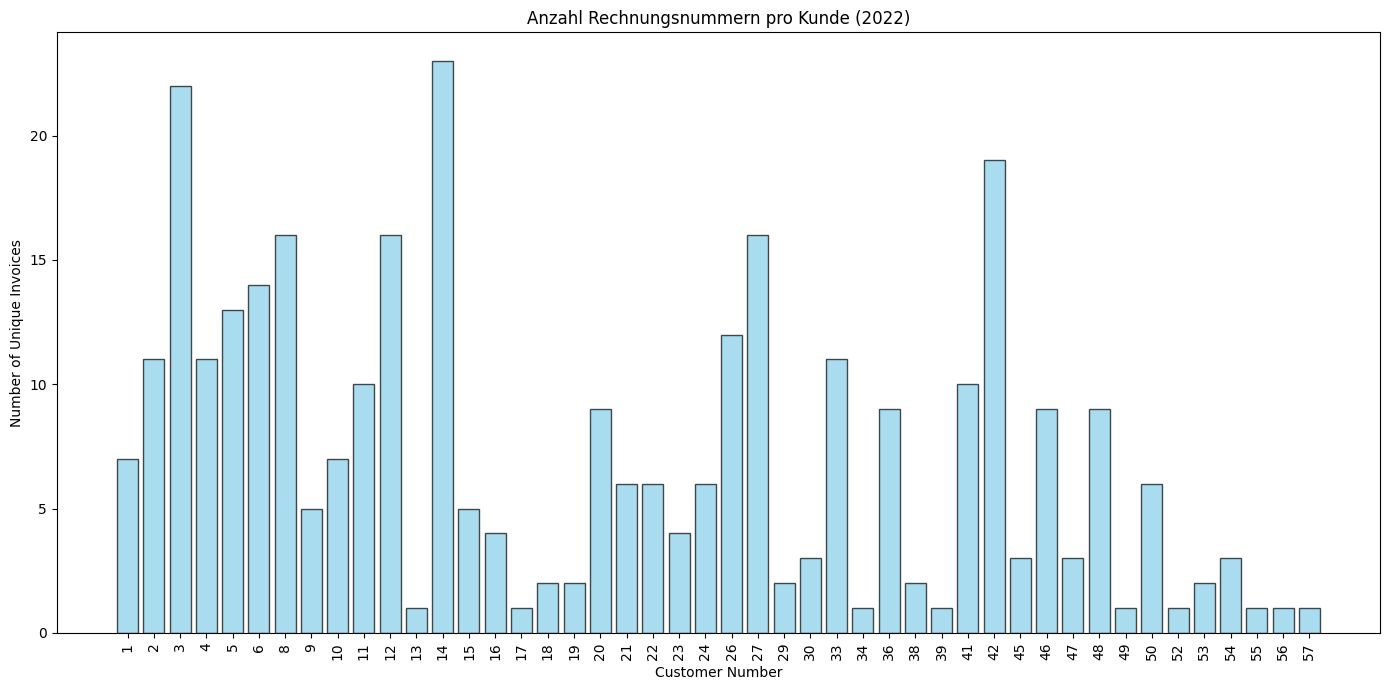

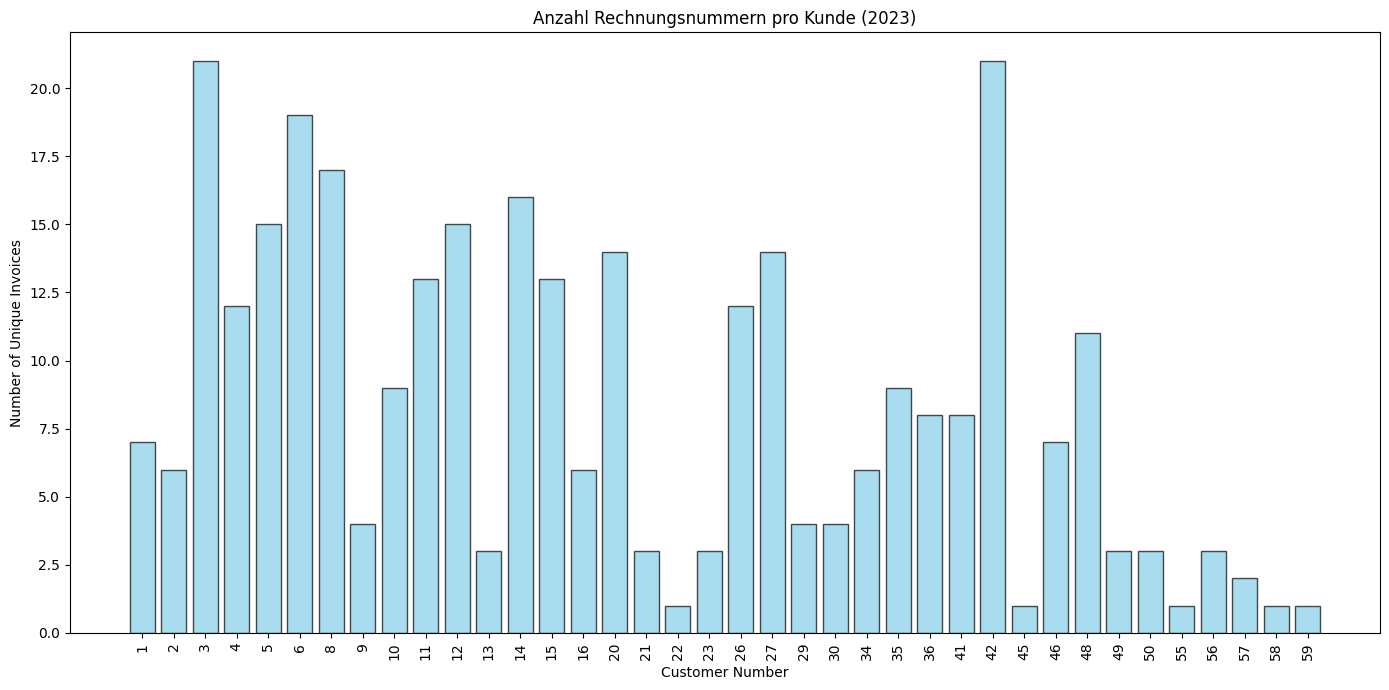

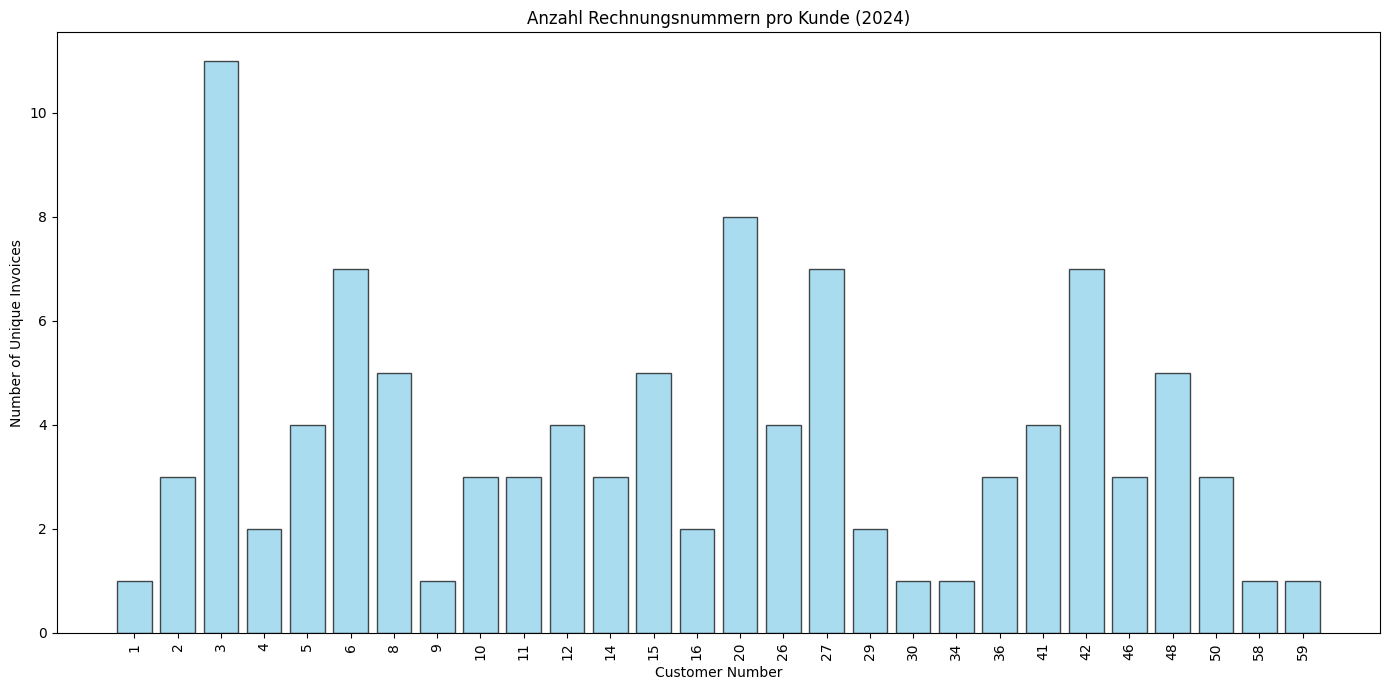

In [ ]:
# Berechnung Anzahl an Rechnungsnummern pro Kunde pro Jahr

data['Year'] = data['Invoice Date'].dt.year

# Berechnung der Anzahl eindeutiger Rechnungen pro Kunde pro Jahr
unique_invoices_per_customer_per_year = data.groupby(['Year', 'Customer Number'])['Invoice Number'].nunique().reset_index()

# Visualisierung pro Jahr
year = unique_invoices_per_customer_per_year['Year'].unique()

for year in year:
    # Filterung der Daten für das aktuelle Jahr
    yearly_data = unique_invoices_per_customer_per_year[unique_invoices_per_customer_per_year['Year'] == year]

    # Erstellung eines Diagramms für das Jahr
    plt.figure(figsize=(14, 7))
    plt.bar(yearly_data['Customer Number'].astype(str), yearly_data['Invoice Number'], color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Anzahl Rechnungsnummern pro Kunde ({year})")
    plt.xlabel("Customer Number")
    plt.ylabel("Number of Unique Invoices")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

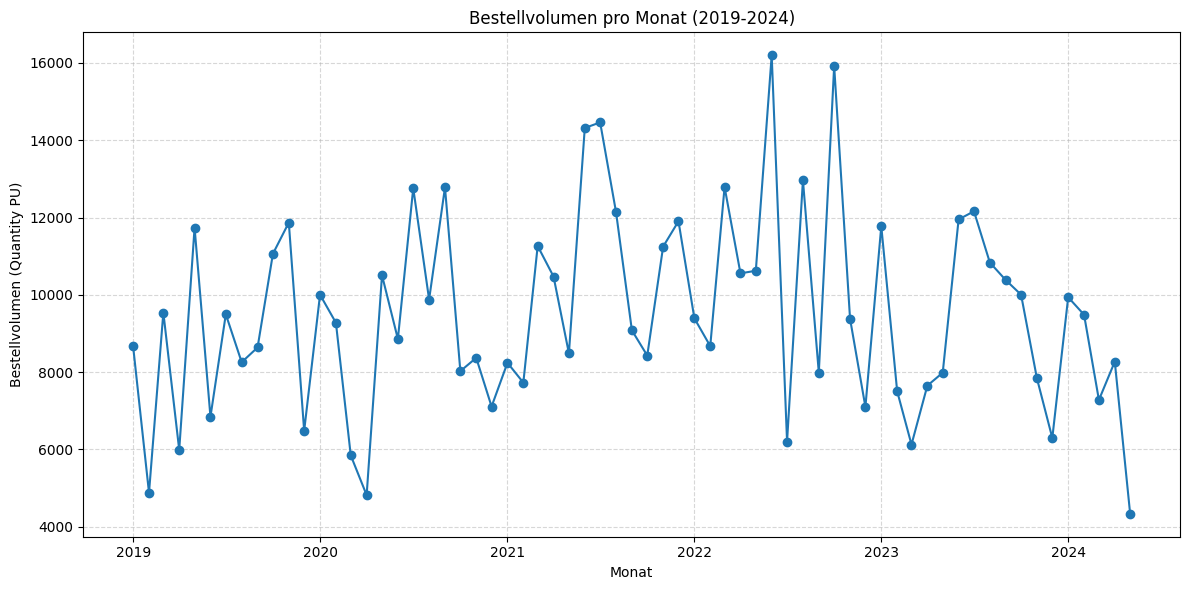

In [ ]:
#Bestellvolumen nach Monat über den Zeitraum 2019-2024

# Berechnung des monatlichen Bestellvolumens
data['Month'] = data['Invoice Date'].dt.to_period('M')  # Konvertierung das Datums in Perioden pro Monat
monthly_volumes = data.groupby('Month')['Quantity PU (Packaging Unit)'].sum()

# Visualisierung des Bestellvolumens
plt.figure(figsize=(12, 6))
plt.plot(monthly_volumes.index.to_timestamp(), monthly_volumes, marker='o')
plt.title("Bestellvolumen pro Monat (2019-2024)")
plt.xlabel("Monat")
plt.ylabel("Bestellvolumen (Quantity PU)")
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

#4. Saisonale Muster

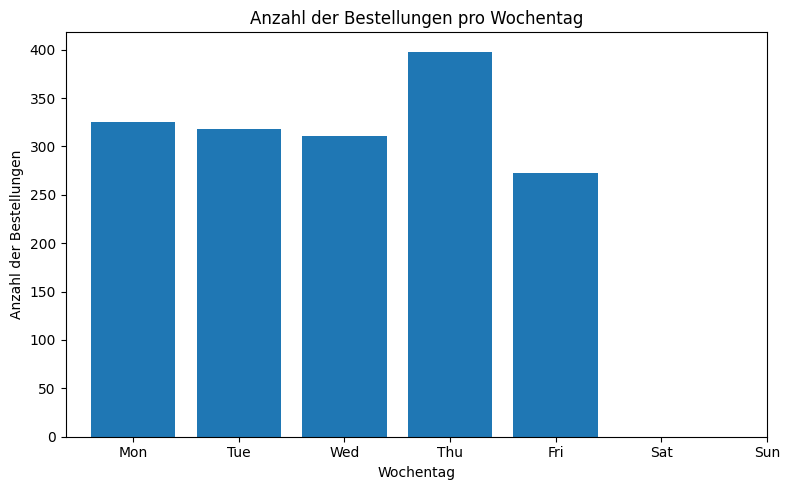

In [ ]:
# Saisonale Muster (Wochentag, Quartal) - Anzahl der Bestellungen

# Extraktion der zeitbezogenen Variablen
data['weekday'] = data['Invoice Date'].dt.weekday  # Wochentage (0 = Montag, 6 = Sonntag)
data['quarter'] = data['Invoice Date'].dt.quarter  # Quartale (1-4)
data['month'] = data['Invoice Date'].dt.month      # Monate (1-12)

# Berechnung der Anzahl der Bestellungen pro Monat pro Kunde
monthly_orders_per_customer = data.groupby(['Customer Number', 'month'])['Invoice Number'].nunique().reset_index()

# Berechnung des gleitenden Durchschnitts (3 Monate) für Bestellungen pro Kunde
monthly_orders_per_customer['rolling_avg_orders'] = (
    monthly_orders_per_customer.groupby('Customer Number')['Invoice Number']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

# Analyse der Anzahl der Bestellungen pro Wochentag
weekday_orders = data.groupby('weekday')['Invoice Number'].nunique().reset_index()

# Visualisierung der Anzahl der Bestellungen pro Wochentag
plt.figure(figsize=(8, 5))
plt.bar(weekday_orders['weekday'], weekday_orders['Invoice Number'])
plt.title("Anzahl der Bestellungen pro Wochentag")
plt.xlabel("Wochentag")
plt.ylabel("Anzahl der Bestellungen")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

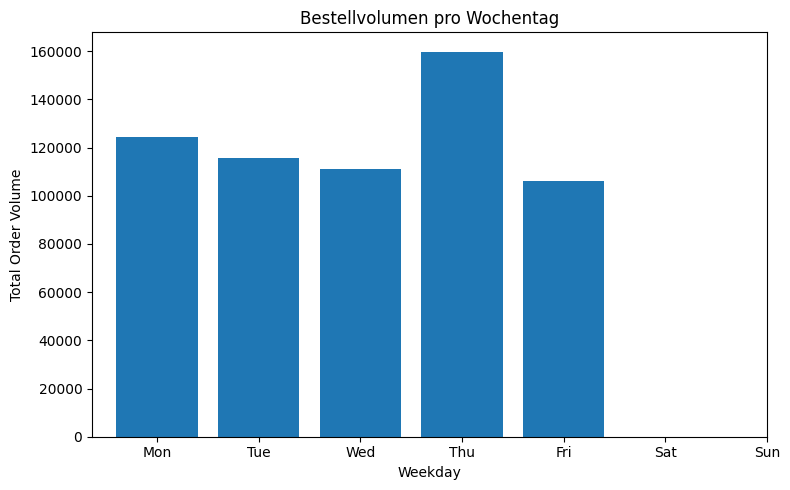

In [ ]:
# Saisonale Muster (Wochentag, Quartal)

# Extrahierung zeitbezogener Variablen
data['weekday'] = data['Invoice Date'].dt.weekday  # Weekdays (0 = Monday, 6 = Sunday)
data['quarter'] = data['Invoice Date'].dt.quarter  # Quarter
data['month'] = data['Invoice Date'].dt.month      # Month

# Berechnung saisonaler Muster: Durchschnittliche Bestellungen der letzten 3 Monate
data['rolling_avg_orders'] = (
    data.groupby('Customer Number')['Quantity PU (Packaging Unit)']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Analyse der Bestellungen nach Wochentagen
weekday_orders = data.groupby('weekday')['Quantity PU (Packaging Unit)'].sum().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(weekday_orders['weekday'], weekday_orders['Quantity PU (Packaging Unit)'])
plt.title("Bestellvolumen pro Wochentag")
plt.xlabel("Weekday")
plt.ylabel("Total Order Volume")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

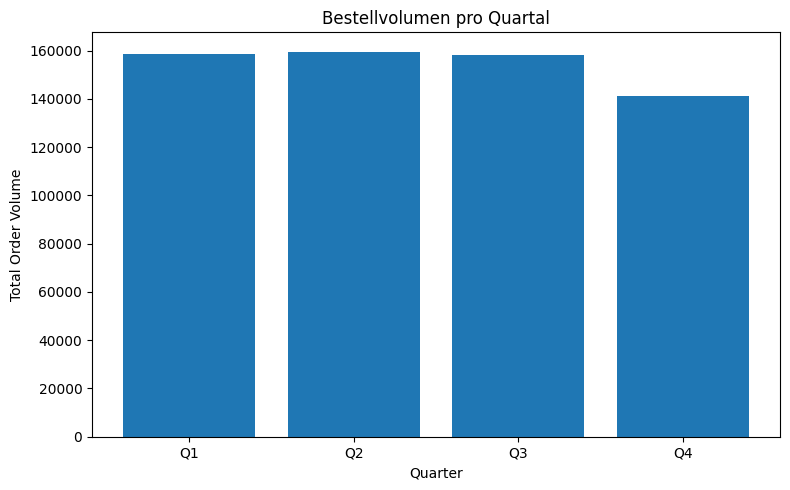

In [ ]:
# Analyse der Bestellungen nach Quartalen
quarter_orders = data.groupby('quarter')['Quantity PU (Packaging Unit)'].sum().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(quarter_orders['quarter'], quarter_orders['Quantity PU (Packaging Unit)'])
plt.title("Bestellvolumen pro Quartal")
plt.xlabel("Quarter")
plt.ylabel("Total Order Volume")
plt.xticks(range(1, 5), ['Q1', 'Q2', 'Q3', 'Q4'])
plt.tight_layout()
plt.show()

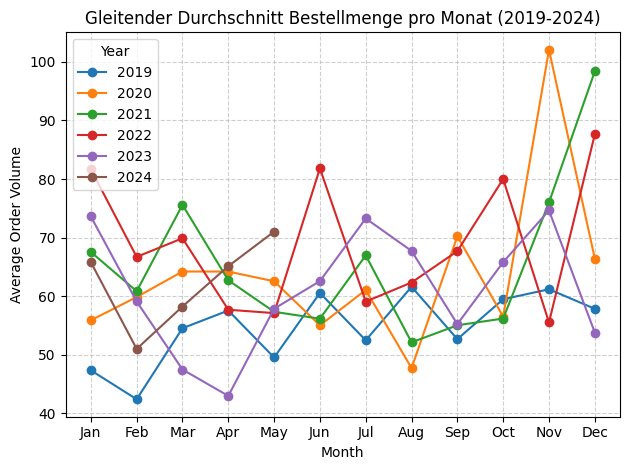

In [ ]:
# Monat und Jahr für Aggregation extrahieren
data['month'] = data['Invoice Date'].dt.month
data['year'] = data['Invoice Date'].dt.year

# Gruppierung nach Monaten und Jahren um durchschnittliches Bestellvolumen über alle Kunden hinweg zu berechnen
monthly_avg_orders = (
    data.groupby(['year', 'month'])['Quantity PU (Packaging Unit)']
    .mean()
    .reset_index()
    .sort_values(by=['year', 'month'])
)

#  Visualisierung: Ein Graph pro betrachtetem Jahr
year = monthly_avg_orders['year'].unique()

for year in year:

    year_data = monthly_avg_orders[monthly_avg_orders['year'] == year]


    plt.plot(year_data['month'], year_data['Quantity PU (Packaging Unit)'], marker='o', label=f"{year}")


plt.title("Gleitender Durchschnitt Bestellmenge pro Monat (2019-2024)")
plt.xlabel("Month")
plt.ylabel("Average Order Volume")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

#5. Produktanalyse

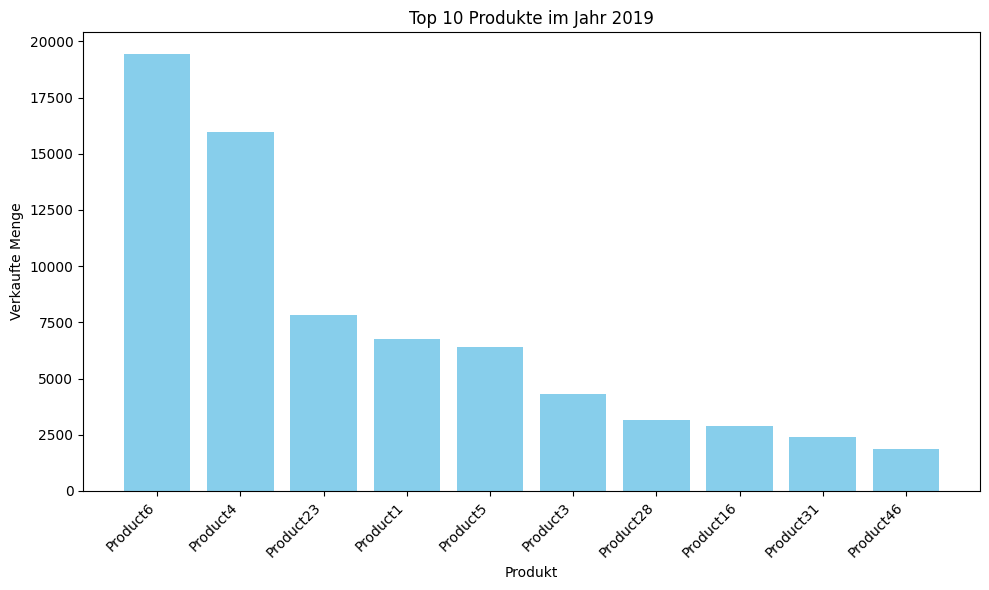

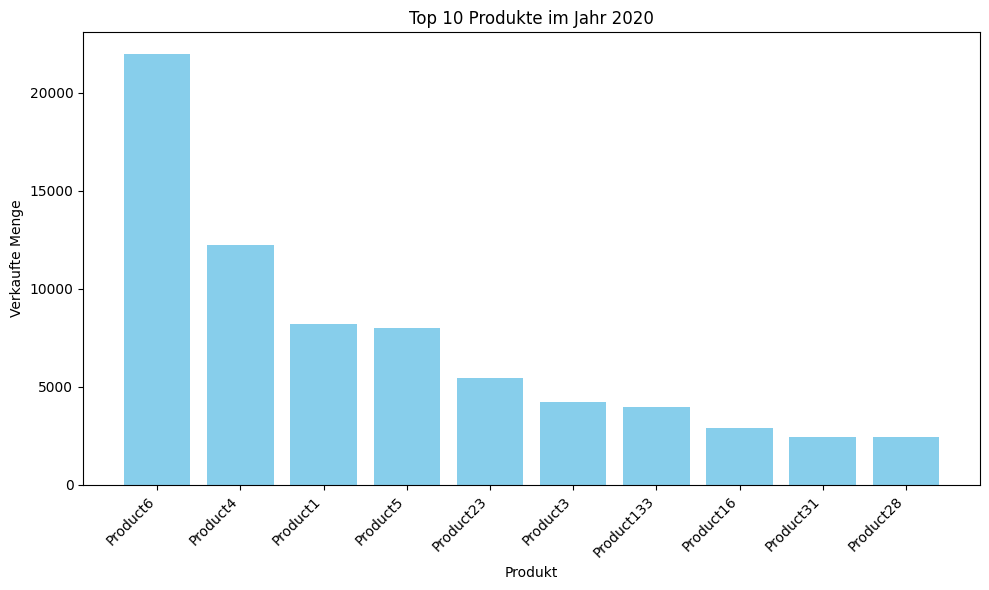

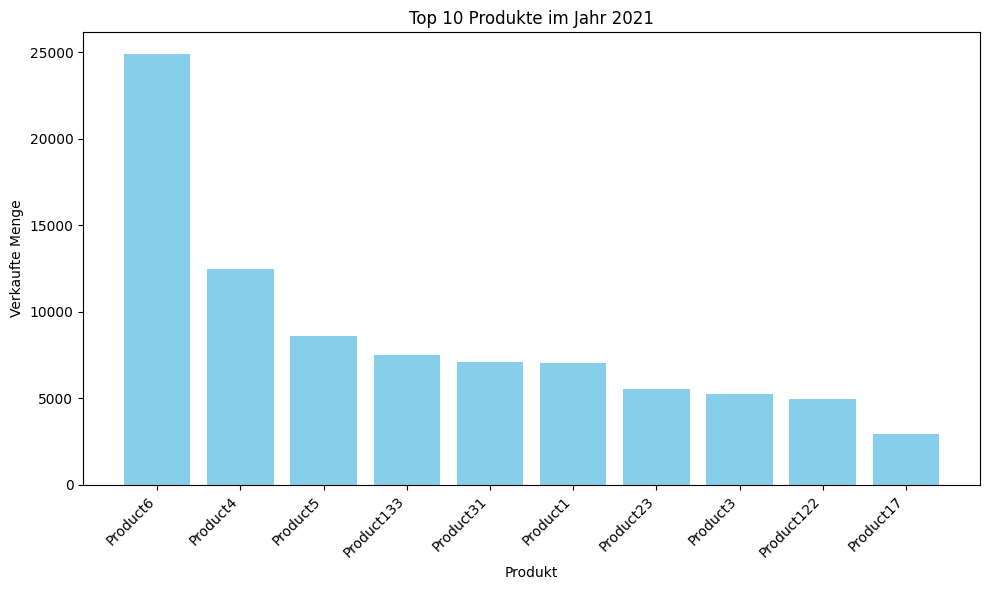

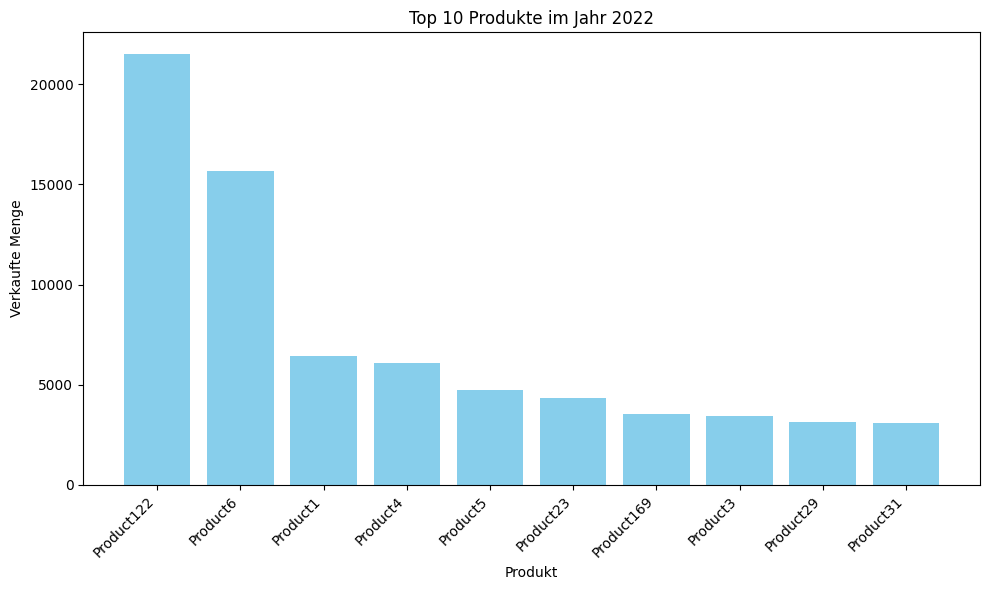

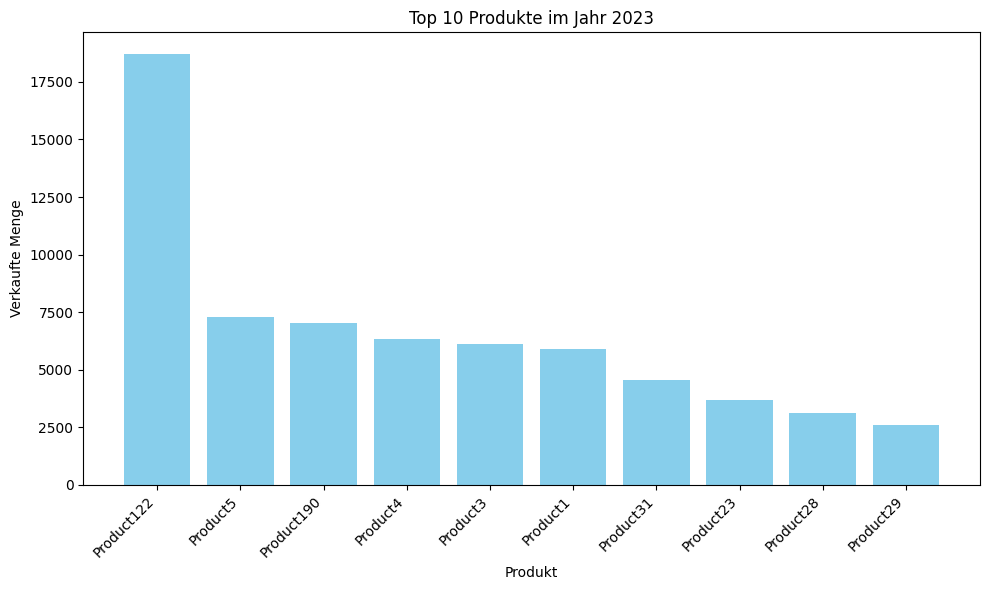

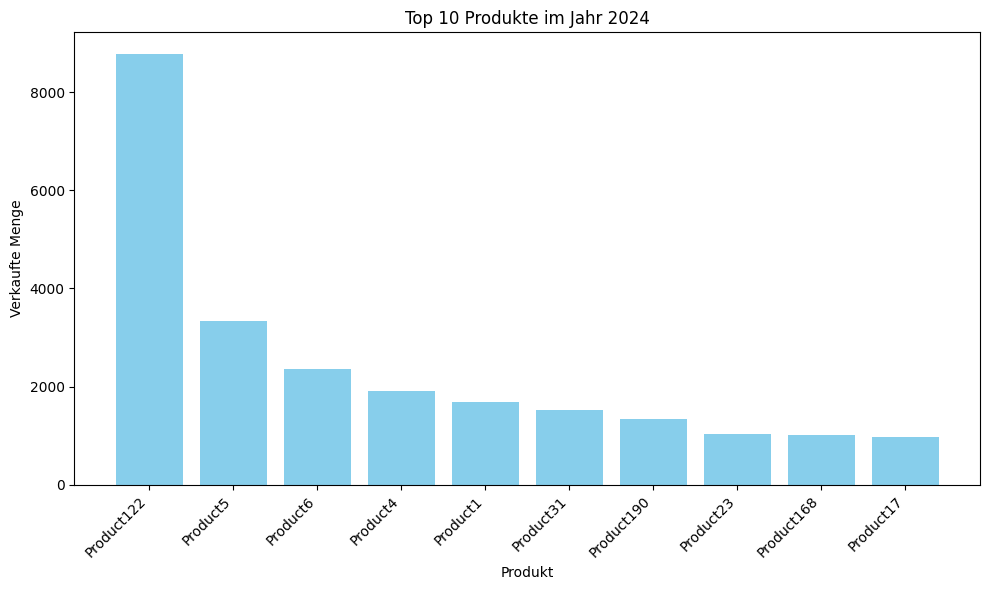

In [ ]:
#Top 10 der meistverkauften Produkte

data['Year'] = data['Invoice Date'].dt.year

# Gruppierung nach Jahr und Produkt, Aufsummierung der Verkaufsmenge
yearly_top_products = (
    data.groupby(['Year', 'Product'])['Quantity PU (Packaging Unit)']
    .sum()
    .reset_index()
    .sort_values(by=['Year', 'Quantity PU (Packaging Unit)'], ascending=[True, False])
)

# Top 10 Produkte pro Jahr
top_10_per_year = yearly_top_products.groupby('Year').head(10)

# Visualisierung der Top 10 Produkte pro Jahr
year = top_10_per_year['Year'].unique()

for year in year:
    # Filterung der Daten für das aktuelle Jahr
    yearly_data = top_10_per_year[top_10_per_year['Year'] == year]

    # Plot Erstellung
    plt.figure(figsize=(10, 6))
    plt.bar(yearly_data['Product'], yearly_data['Quantity PU (Packaging Unit)'], color='skyblue')
    plt.title(f"Top 10 Produkte im Jahr {year}")
    plt.xlabel("Produkt")
    plt.ylabel("Verkaufte Menge")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

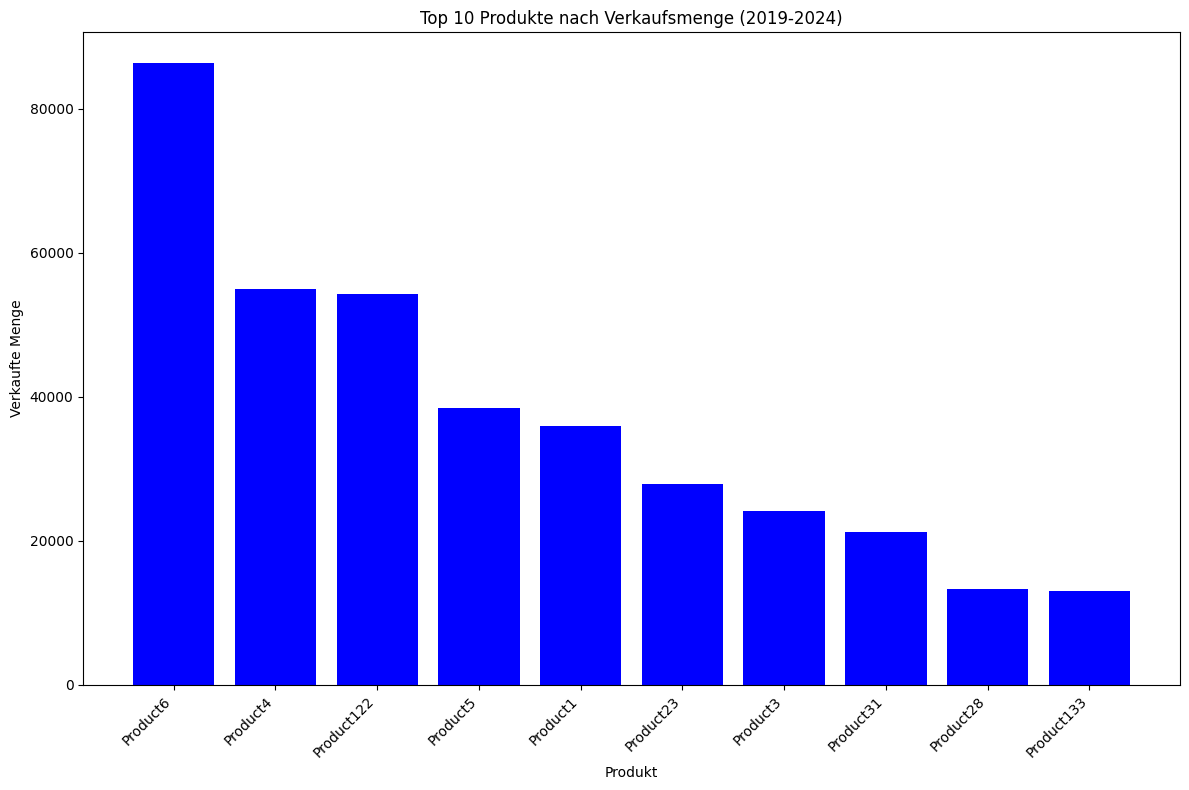

In [ ]:
# Top 10 Produkte über alle Jahre hinweg
overall_top_products = (
    data.groupby('Product')['Quantity PU (Packaging Unit)']
    .sum()
    .reset_index()
    .sort_values(by='Quantity PU (Packaging Unit)', ascending=False)
    .head(10)
)

# Visualisierung der Top 10 Produkte über alle Jahre
plt.figure(figsize=(12, 8))
plt.bar(overall_top_products['Product'], overall_top_products['Quantity PU (Packaging Unit)'], color='blue')
plt.title("Top 10 Produkte nach Verkaufsmenge (2019-2024)")
plt.xlabel("Produkt")
plt.ylabel("Verkaufte Menge")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Kundensegmentierung

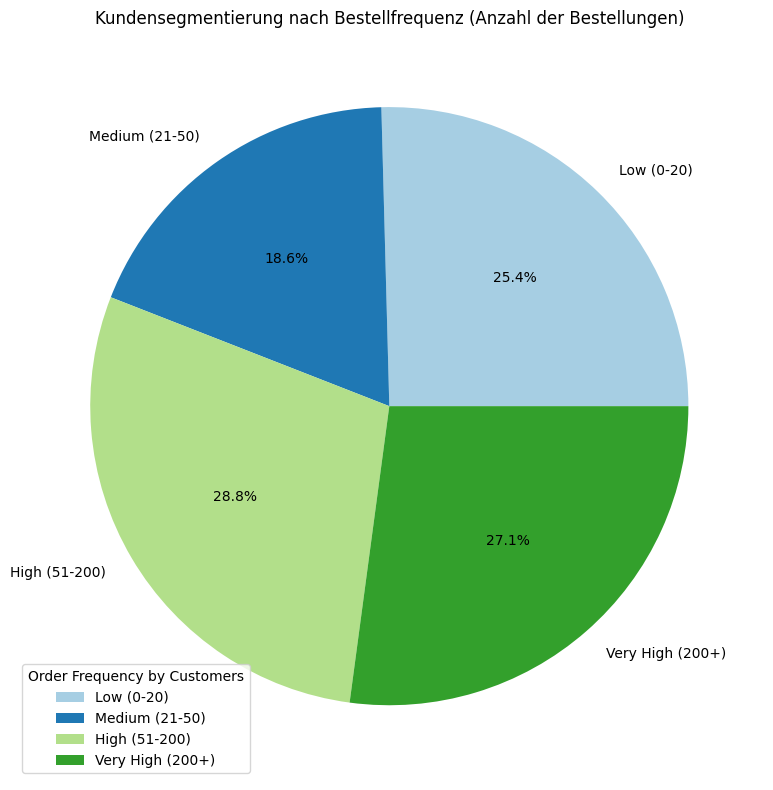

In [ ]:
#Kundensegmentierung nach Bestellhäufigkeit

# Segmentierung nach Bestellhäufigkeit
order_frequency = data.groupby('Customer Number')['Invoice Date'].count()

# Definition der Bins und Labels
frequency_bins = [0, 20, 50, 200, order_frequency.max()]
frequency_labels = ['Low (0-20)', 'Medium (21-50)', 'High (51-200)', 'Very High (200+)']

# Segmentierung
frequency_segments = pd.cut(order_frequency, bins=frequency_bins, labels=frequency_labels)

# Zählung der Kunden in jeder Kategorie
frequency_segment_counts = frequency_segments.value_counts(sort=False)

# Plot: Segmentierung nach Bestellhäufigkeit
plt.figure(figsize=(8, 8))
frequency_segment_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=plt.cm.Paired(range(len(frequency_segment_counts))),
    labels=frequency_segment_counts.index
)
plt.title("Kundensegmentierung nach Bestellfrequenz (Anzahl der Bestellungen)")
plt.ylabel("")
plt.legend(
    labels=[f'{label}' for i, label in enumerate(frequency_labels)],
    loc="best",
    title="Order Frequency by Customers"
)
plt.tight_layout()
plt.show()

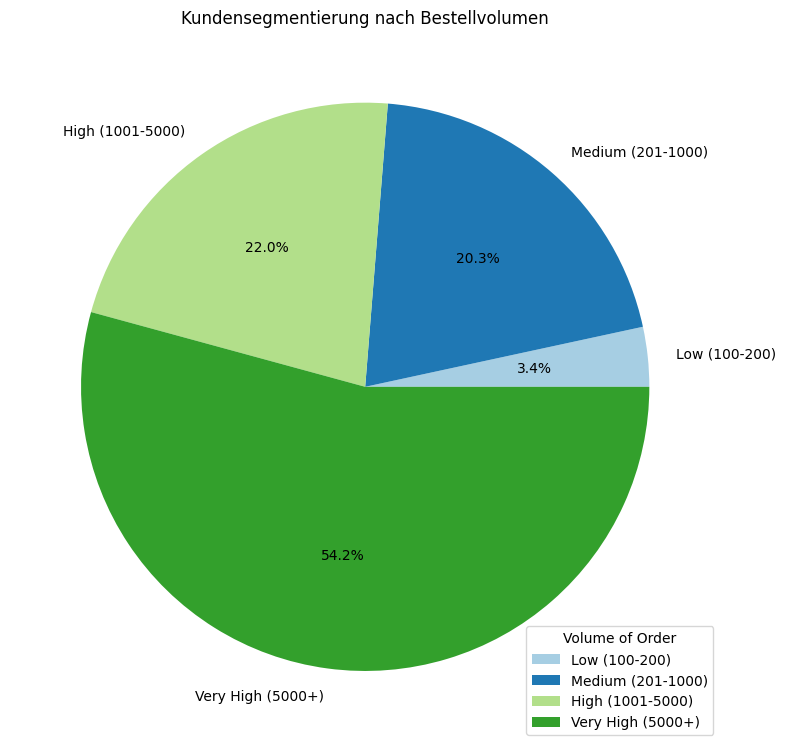

In [ ]:
#Kundensegmentierung nach Bestellvolumen

# Segmentierung nach Bestellvolumen
order_volume = data.groupby('Customer Number')['Quantity PU (Packaging Unit)'].sum()

# Definition der Bins und Labels
volume_bins = [100, 200, 1000, 5000, order_volume.max()]
volume_labels = ['Low (100-200)', 'Medium (201-1000)', 'High (1001-5000)', 'Very High (5000+)']

# Segmentierung
volume_segments = pd.cut(order_volume, bins=volume_bins, labels=volume_labels)

# Zählung der Kunden in jeder Kategorie
volume_segment_counts = volume_segments.value_counts(sort=False)

# Plot: Segmentierung nach Bestellvolumen
plt.figure(figsize=(8, 8))
volume_segment_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=plt.cm.Paired(range(len(volume_segment_counts))),
    labels=volume_segment_counts.index
)
plt.title("Kundensegmentierung nach Bestellvolumen")
plt.ylabel("")
plt.legend(
    labels=[f'{label}' for i, label in enumerate(volume_labels)],
    loc="best",
    title="Volume of Order"
)
plt.tight_layout()
plt.show()

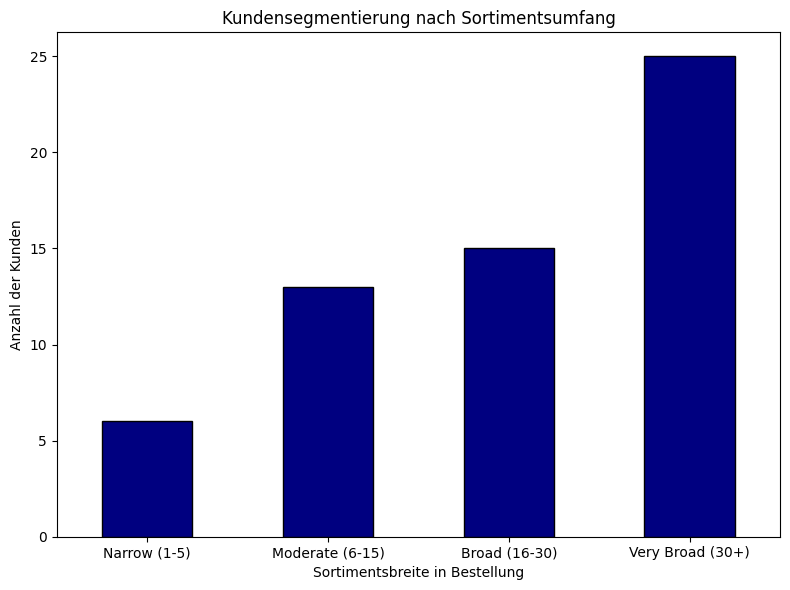

In [ ]:
# Berechnung der Sortimentsbreite pro Kunde (Anzahl der verschiedenen Produkte)

customer_products = data.groupby('Customer Number')['Product'].nunique()

# Definierung Sortimentsbreite
product_bins = [0, 5, 15, 30, customer_products.max()]
product_labels = ['Narrow (1-5)', 'Moderate (6-15)', 'Broad (16-30)', 'Very Broad (30+)']
customer_product_segments = pd.cut(customer_products, bins=product_bins, labels=product_labels)

# Ergebisse der Segmentierung
product_segment_counts = customer_product_segments.value_counts(sort=False)

# Visualisierung
plt.figure(figsize=(8, 6))
product_segment_counts.plot(kind='bar', color='navy', edgecolor='black')
plt.title("Kundensegmentierung nach Sortimentsumfang")
plt.xlabel("Sortimentsbreite in Bestellung")
plt.ylabel("Anzahl der Kunden")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

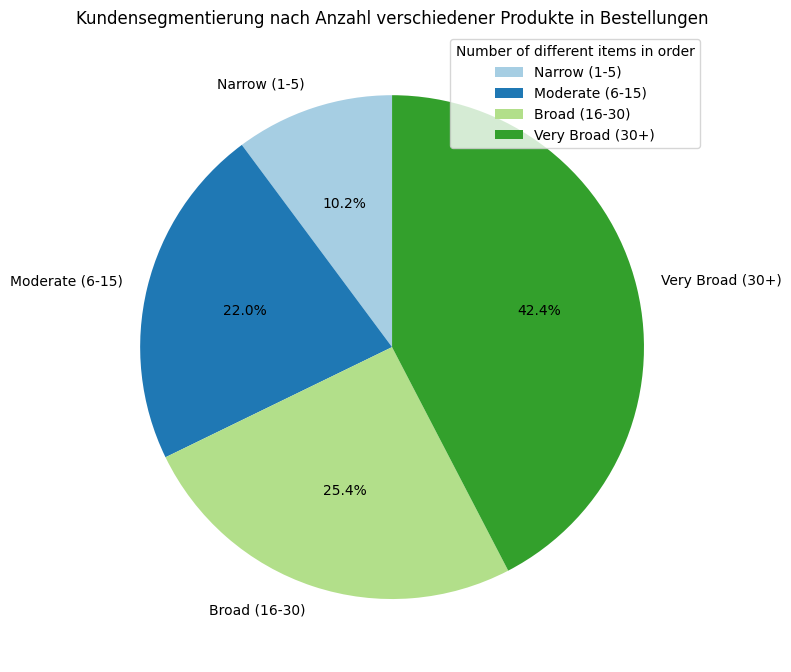

In [ ]:
# Visualisierung der Segmentverteilung (Kreisdiagramm)
plt.figure(figsize=(8, 8))
product_segment_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=plt.cm.Paired(range(len(product_segment_counts))),
    labels=product_segment_counts.index,
    startangle=90
)
plt.title("Kundensegmentierung nach Anzahl verschiedener Produkte in Bestellungen")
plt.ylabel("")
plt.legend(
    labels=[f'{label}' for i, label in enumerate(product_labels)],
    loc="best",
    title="Number of different items in order"
)
plt.tight_layout()
plt.show()

# 7. Korellationsmatrix

In [ ]:
#Entfernung des String "Product" in Spalte "Product" und behalten der Zahlenwerte als Integer
data['Product'] = data['Product'].str.replace('Product', '', regex=False).astype(int)

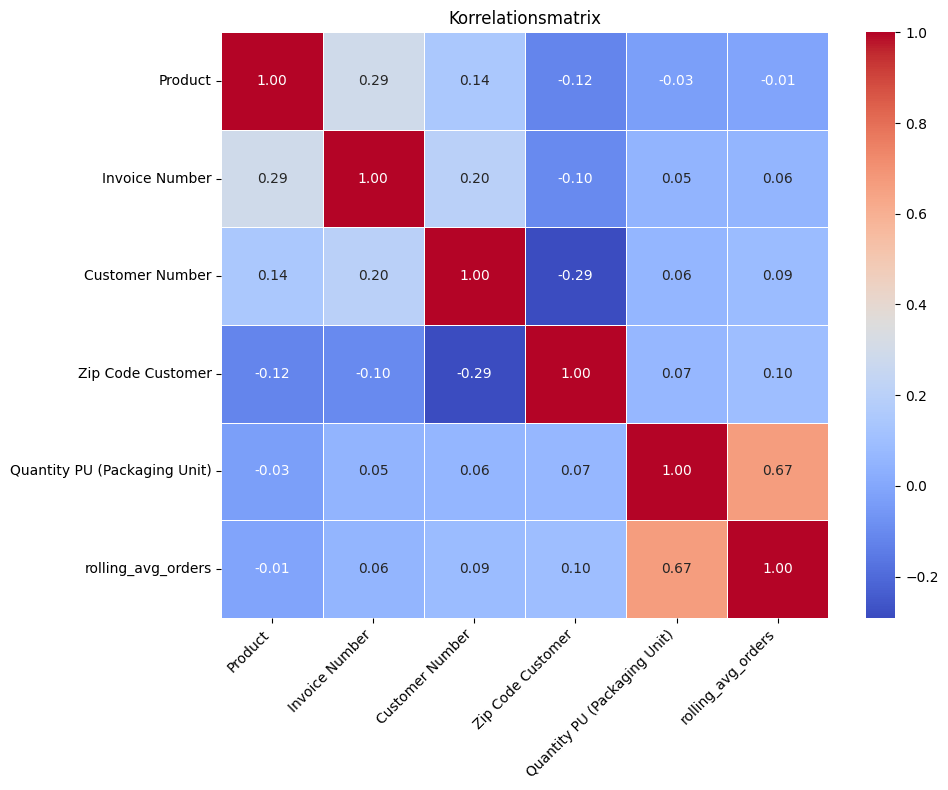

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Korellationsmatrix zwischen numerischen Features

# Selektierung von nur numerischen Spalten für die Korrelationsmatrix
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Berechnung der Korrelationsmatrix
correlation_matrix = numerical_data.corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Korrelationsmatrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#8. Vorhersagemodell

#8.1 Random Forest Modell

Root Mean Squared Error (RMSE): 41.09465268070006


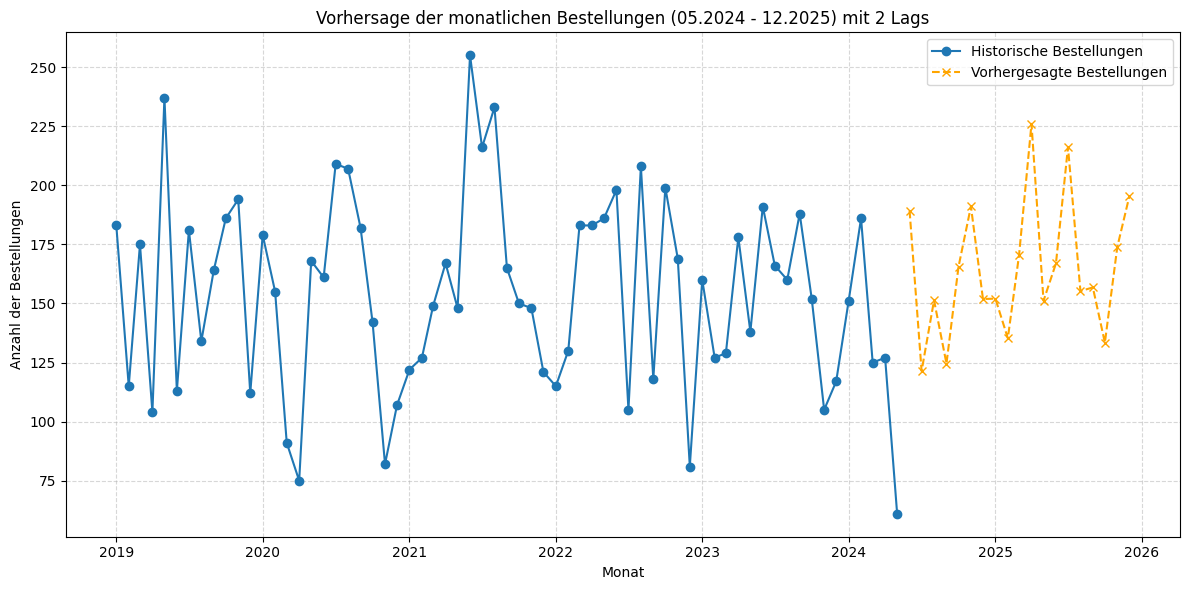

Trainingsdaten: 69.84%
Testdaten: 30.16%


In [ ]:
# Definierung der Anzahl der Lags
max_lags = 2

# Berechne die monatliche Anzahl der Bestellungen
data['Month'] = data['Invoice Date'].dt.to_period('M')
monthly_orders = data.groupby('Month')['Invoice Date'].count().reset_index()
monthly_orders.rename(columns={'Invoice Date': 'Order Count'}, inplace=True)

# Erstellung von Lag-Features dynamisch
for lag in range(1, max_lags + 1):
    monthly_orders[f'Lag{lag}'] = monthly_orders['Order Count'].shift(lag)

# Entfernung von Zeilen mit fehlenden Lag-Werten
model_data = monthly_orders.dropna().reset_index(drop=True)

# Sortierung der Daten nach Zeitreihe
model_data = model_data.sort_values(by='Month')

# 70/30-Split auf Basis der Zeitreihe
split_index = int(len(model_data) * 0.70)
train_data = model_data.iloc[:split_index].copy()
test_data = model_data.iloc[split_index:].copy()

# Sicherstellen, dass der erste Monat des Testdatensatzes auf den letzten Monat des Trainingsdatensatzes folgt
test_data = test_data[test_data['Month'] > train_data['Month'].max()]

# Definierung von Features und Zielvariablen
X_train, y_train = train_data[[f'Lag{i}' for i in range(1, max_lags + 1)]], train_data['Order Count']
X_test, y_test = test_data[[f'Lag{i}' for i in range(1, max_lags + 1)]], test_data['Order Count']

# Modelltraining
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersage für Testdaten
y_test_pred = model.predict(X_test)

# Fehlerberechnung
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Vorhersage für die Zukunft
future_months = pd.period_range(model_data['Month'].max() + 1, '2025-12', freq='M')
predictions = []


last_known_values = train_data.iloc[-max_lags:]['Order Count'].values.tolist()

for month in future_months:
    lag_features = pd.DataFrame([last_known_values[-max_lags:]], columns=[f'Lag{i}' for i in range(1, max_lags + 1)])
    predicted_value = model.predict(lag_features)[0]
    predictions.append({'Month': month, 'Predicted Order Count': predicted_value})
    last_known_values.append(predicted_value)

# Ergebnisse speichern
predictions_data = pd.DataFrame(predictions)

# Visualisierung
historical_data = monthly_orders[['Month', 'Order Count']].copy()
historical_data['Month'] = historical_data['Month'].dt.to_timestamp()
predictions_data['Month'] = predictions_data['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(historical_data['Month'], historical_data['Order Count'], label="Historische Bestellungen", marker='o')
plt.plot(predictions_data['Month'], predictions_data['Predicted Order Count'], label="Vorhergesagte Bestellungen", linestyle='--', marker='x', color='orange')
plt.title(f"Vorhersage der monatlichen Bestellungen (05.2024 - 12.2025) mit {max_lags} Lags")
plt.xlabel("Monat")
plt.ylabel("Anzahl der Bestellungen")
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# Prozentuale Verteilung
training_percentage = (len(train_data) / len(model_data)) * 100
test_percentage = (len(test_data) / len(model_data)) * 100

print(f"Trainingsdaten: {training_percentage:.2f}%")
print(f"Testdaten: {test_percentage:.2f}%")


#8.2 ARIMA Modell

In [ ]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

ADF-Test Statistik: -4.7162
p-Wert: 0.0001
Die Zeitreihe ist stationär!
RMSE auf den Trainingsdaten: 35.53


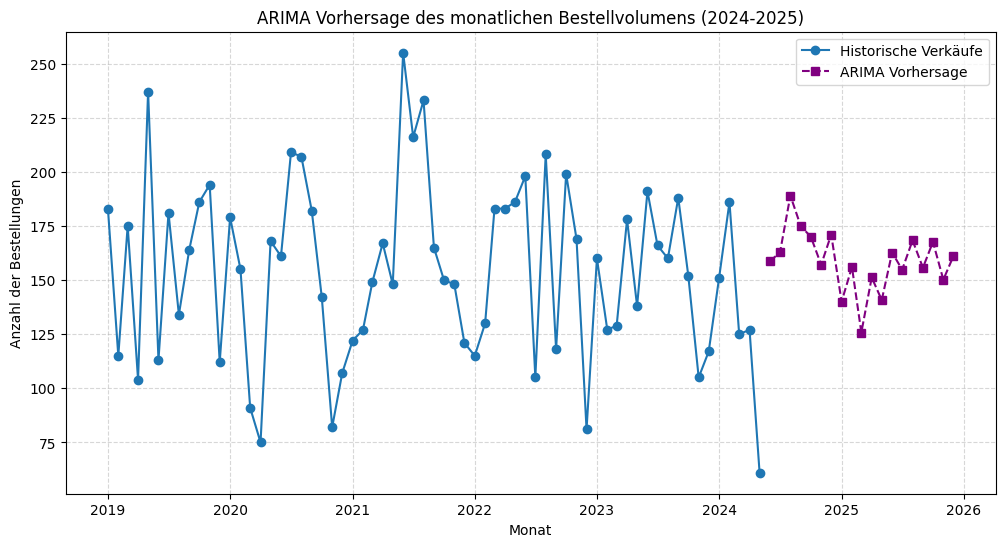

In [ ]:
# Datenvorbereitung
data['Month'] = data['Invoice Date'].dt.to_period('M')
monthly_orders = data.groupby('Month')['Invoice Date'].count().reset_index()
monthly_orders.rename(columns={'Invoice Date': 'Order Count'}, inplace=True)

# Setzung von 'Month' als Index für ARIMA
monthly_orders.set_index('Month', inplace=True)
monthly_orders = monthly_orders.asfreq('M')  # Sicherstellen, dass die Daten monatlich sind

# Stationarität prüfen (Augmented Dickey-Fuller-Test)
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF-Test Statistik: {result[0]:.4f}')
    print(f'p-Wert: {result[1]:.4f}')
    if result[1] > 0.05:
        print("Die Zeitreihe ist nicht stationär! Differenzierung nötig (d=1).")
    else:
        print("Die Zeitreihe ist stationär!")

check_stationarity(monthly_orders)

# ARIMA-Modell trainieren (manuell optimierte Parameter)
p, d, q = 10, 0, 2  # Manuelle Parameterwahl

arima_model = sm.tsa.ARIMA(monthly_orders, order=(p, d, q))
arima_results = arima_model.fit()

# 4️. Vorhersagen für 2024-2025
future_months = pd.date_range('2024-06-01', '2025-12-01', freq='MS').to_period('M')

forecast = arima_results.get_forecast(steps=len(future_months))
conf_int = forecast.conf_int()
forecast_values = forecast.predicted_mean

# PeriodIndex zu Timestamp konvertieren
future_months = future_months.to_timestamp()

# Berechnung des RMSE
# RMSE für die Trainingsdaten (ARIMA-Fitted Values vs. Tatsächliche Werte)
train_pred = arima_results.fittedvalues
train_rmse = np.sqrt(mean_squared_error(monthly_orders[d:], train_pred[d:]))

print(f"RMSE auf den Trainingsdaten: {train_rmse:.2f}")

# Visualisierung der ARIMA-Vorhersage
plt.figure(figsize=(12, 6))

# Historische Werte
plt.plot(monthly_orders.index.to_timestamp(), monthly_orders, label="Historische Verkäufe", marker='o')

# ARIMA Vorhersage
plt.plot(future_months, forecast_values, label="ARIMA Vorhersage", linestyle='--', color='purple', marker='s')

plt.title("ARIMA Vorhersage des monatlichen Bestellvolumens (2024-2025)")
plt.xlabel("Monat")
plt.ylabel("Anzahl der Bestellungen")
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

#8.3 Überprüfung auf Saisonalität (SARIMA testen)

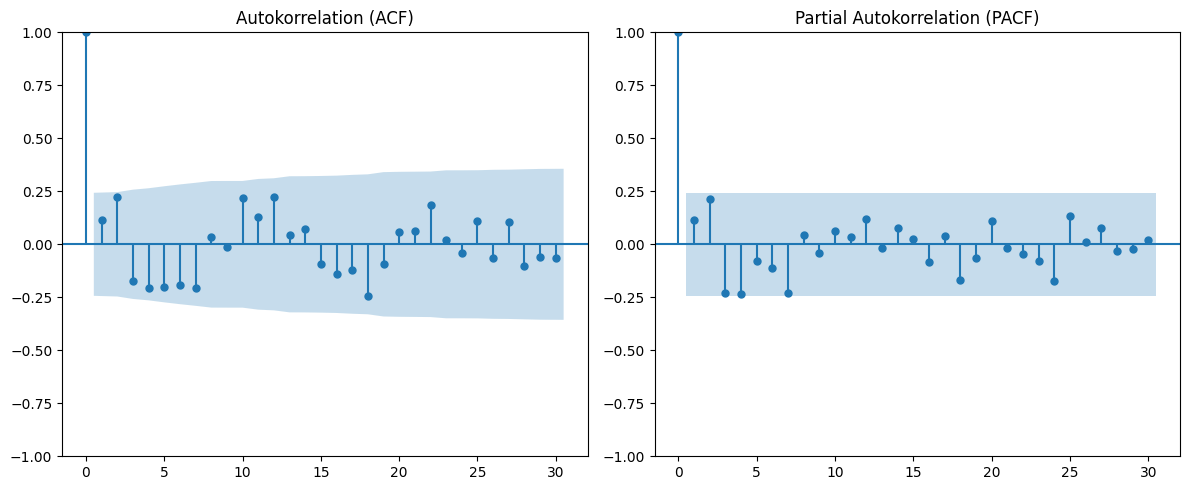

In [ ]:
#Überprüfung auf Saisonalität
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(monthly_orders, lags=30, ax=plt.gca())
plt.title("Autokorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(monthly_orders, lags=30, ax=plt.gca())
plt.title("Partial Autokorrelation (PACF)")

plt.tight_layout()
plt.show()
#Falls starke Peaks alle 12 Monate auftreten, ist SARIMA sinnvoll